# BranchPro: inference of R_t with negative binomial noise

The first part of the notebook includes a forward simulation of the incidence numbers for an example branching process model with negative binomial noise. The reproduction number profile is assumed to be a step function with only one jump.

The second part of the notebook focuses on the computation of the posterior of the reproduction number for the inference using the data from the previous section, using two methods:
- using the posterior class implementation.

The mean and 95% interval quantiles are plotted together to illustrate a sensible trajectory of the R profile in time for both methods of inference.

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import plotly.graph_objects as go
import pandas as pd
import stan
import arviz as az
import nest_asyncio
nest_asyncio.apply()


num_timepoints = 30 # number of days for incidence data


## Parameterize example branching process model

In [2]:
# Build the serial interval w_s
ws_mean = 2.6
ws_var = 1.5**2
theta = ws_var / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(num_timepoints))

# Simulate incidence data
initial_r = 3
serial_interval = disc_w
phi = 0.0005

m = branchpro.NegBinBranchProModel(initial_r, serial_interval, phi)
new_rs = [3, 0.5]          # sequence of R_0 numbers
start_times = [0, 15]      # days at which each R_0 period begins
m.set_r_profile(new_rs, start_times)
parameters = 100 # initial number of cases
times = np.arange(num_timepoints)

cases = m.simulate(parameters, times)
print(cases)

[ 100.    0.   73.   80.  134.  126.  242.  328.  455.  560.  888. 1202.
 1656. 2229. 3314. 4344. 1028. 1348. 1373. 1121.  938.  785.  637.  502.
  454.  379.  301.  250.  211.  182.]


## Plot local incidence numbers

In [3]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=cases,
        name='Incidences'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

fig.show()

## Compute the posterior distribution using sampling class method

In [4]:
# Same inference, but using the PoissonBranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

phi_mean = 0.5
phi_var = 10**(-0)
phi_rate = phi_var / phi_mean
phi_shape = phi_mean / phi_rate

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': cases
    }
)

L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1]+1, num_timepoints))

ground_truth = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'R_t': L1*[3] + L2*[0.5]
})

inference_new = branchpro.NegBinBranchProLogPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    tau=tau,
    phi=phi,
    alpha=a,
    beta=1/b,
    infer_phi=True,
    phi_shape=phi_shape,
    phi_rate=1/phi_rate)


Running...
Using No-U-Turn MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Accept.   Steps. Accept.   Steps. Time m:s
0     18     0.333    1       0.125    2       0.333    1        0:00.0
1     21     0.25     1       0.25     1       0.25     1        0:00.0
2     24     0.25     1       0.25     1       0.25     1        0:00.0
3     33     0.5      2       0.5      2       0.5      2        0:00.0
20    399    0.774    6       0.782    7       0.766    8        0:00.4
40    855    0.756    7       0.734694 8       0.744    8        0:00.7
60    1311   0.747    7       0.782    8       0.763    8        0:01.1
80    1779   0.773    7       0.748    7       0.748    8        0:01.4
100   2053   0.642    6       0.75981  7       0.766    7        0:01.6
Halting: Maximum number of iterations (100) reached.
Done!
param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  --

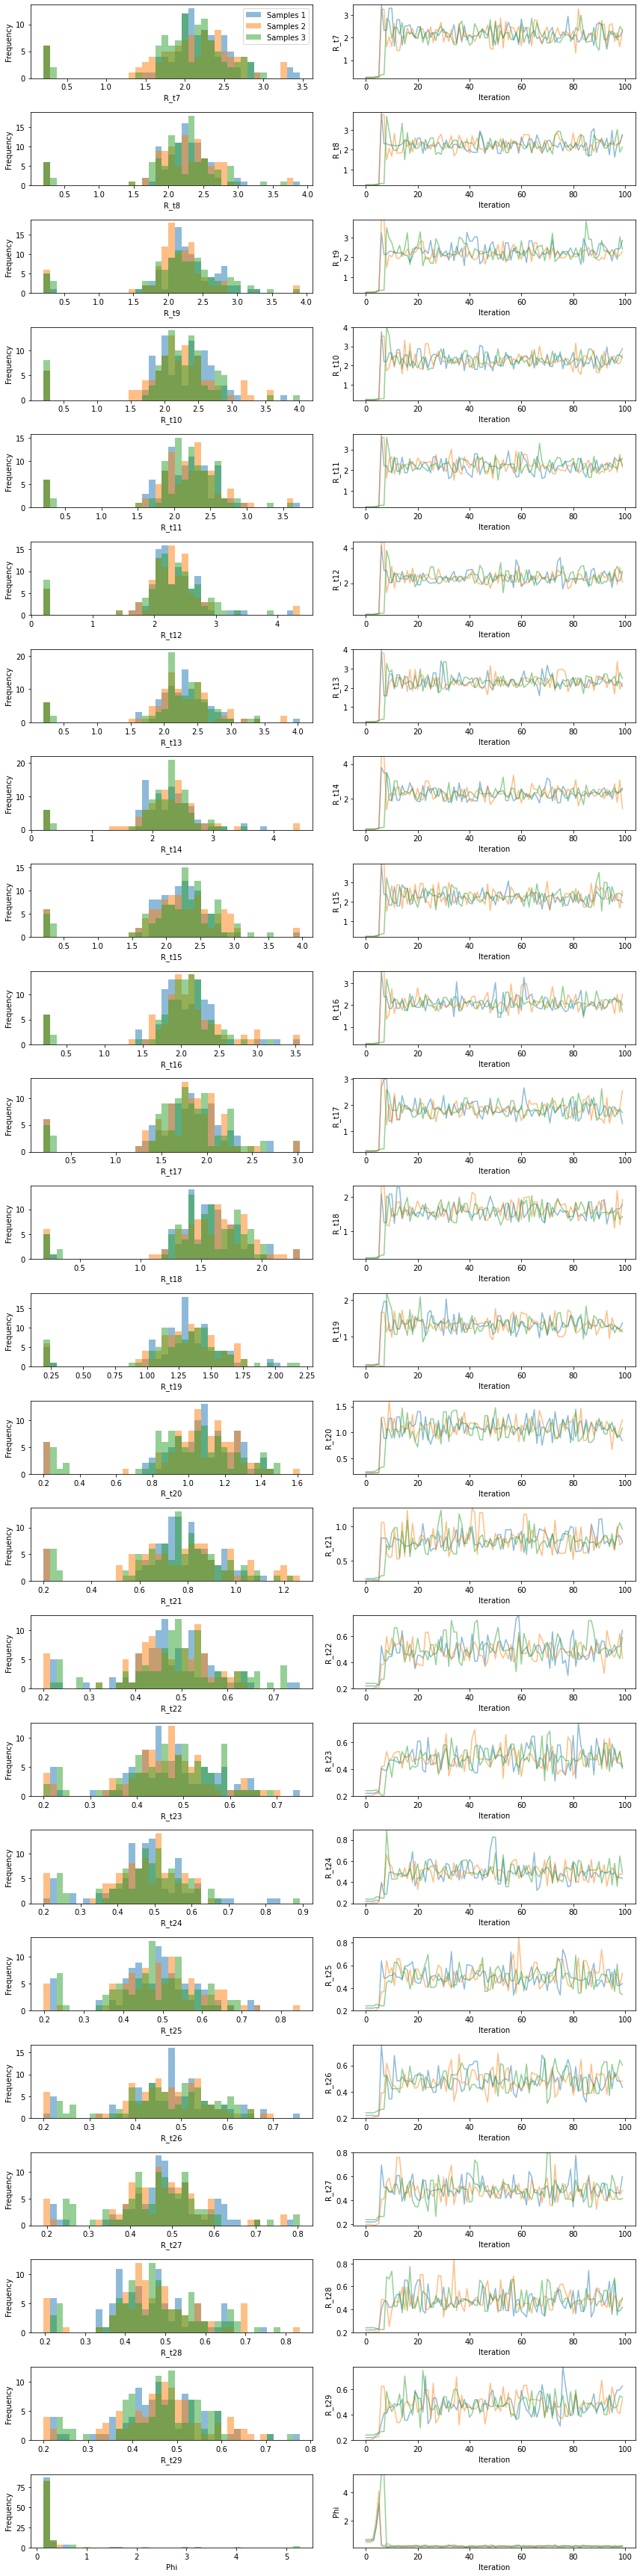

In [5]:
samples = inference_new.run_inference(num_iter=100)

import pints.plot
from matplotlib import pyplot as plt

# Plot histograms of the parameters inferred for South West
param_names = []

if inference_new._infer_phi is True:
    for _ in range(inference_new.lprior.n_parameters()-1):
        param_names.append('R_t{}'.format(_ + R_t_start))
    param_names.append('Phi')

    pints.plot.trace(samples, parameter_names=param_names)
    plt.show()

    # Eliminate burn-in iterations (1/2 of the chain lengths)
    samples_old = samples.copy()
    samples = samples[:, 50:, :-1]

else:
    for _ in range(inference_new.lprior.n_parameters()):
        param_names.append('R_t{}'.format(_ + R_t_start))

    pints.plot.trace(samples, parameter_names=param_names)
    plt.show()

    # Eliminate burn-in iterations (1/2 of the chain lengths)
    samples_old = samples.copy()
    samples = samples[:, 50:, :]

# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = samples.shape

extended_samples = np.concatenate((samples[0], samples[1], samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 50))

new_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[::thinning, :], axis=0),
    'Lower bound CI': np.quantile(extended_samples[::thinning, :], 0.025, axis=0),
    'Upper bound CI': np.quantile(extended_samples[::thinning, :], 0.975, axis=0),
    'Central Probability': (L1+L2) * [0.95]
})

## Inference plot using class method results

In [6]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(new_intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



In [7]:
dLl = []
old_r_profile = ground_truth['R_t'].to_list()

total_time = inference_new.ll.cases_times.max() - inference_new.ll.cases_times.min() + 1
time_init_inf_r = inference_new.ll._tau + 1

if inference_new._infer_phi is True:
    old_r_profile.append(phi)

    for _, time in enumerate(range(time_init_inf_r+1, total_time+2)):
        new_r_profile = old_r_profile.copy()
        new_r_profile[_] = old_r_profile[_] + 10**(-5)
        dLl.append((inference_new.ll(new_r_profile)-inference_new.ll(old_r_profile))/10**(-5))

else:
    for _, time in enumerate(range(time_init_inf_r+1, total_time+1)):
        new_r_profile = old_r_profile.copy()
        new_r_profile[_] = old_r_profile[_] + 10**(-5)
        dLl.append((inference_new.ll(new_r_profile)-inference_new.ll(old_r_profile))/10**(-5))

print(dLl)
print(inference_new.ll._compute_derivative_log_likelihood(old_r_profile))

[-2.1592684788629413, 5.453170160762965, -9.054690599441528, -1.9901250198017804, -0.32998723327182233, 12.834923836635424, -2.3915119527373463, 1.2495715054683387, -15.11593291070312, 18362.510587030556, 16874.51410398353, 15048.23070426937, 12645.261698344255, 9613.388912111986, 5285.266168357339, 17.541824490763247, -23.55178876314312, 86.75988792674616, 91.62754213321021, 51.54995305929332, -20.19925304921344, -75.01481813960709, -69.02912282384932, 23984132.05742181]
[-2.1587721861516656, 5.453876823483597, -9.053790494462902, -1.9889208268405127, -0.3284320185576348, 12.836917506601026, -2.3890691922530323, 1.2525654828705228, -15.112414334658752, 18362.77866791535, 16874.779932958958, 15048.489353044042, 12645.502856217425, 9613.600836093789, 5285.428117026944, 17.635775263867572, -23.46352048850622, 86.84032535054075, 91.69804467978452, 51.61109062288085, -20.14682456678031, -74.97012026780237, -68.99074269465979, 24161758.511928126]


In [8]:
output_optimisation = inference_new.run_optimisation()[0]

shape = []
rate = []
mean = []

i=0

if inference_new._infer_phi is True:
    theta_hat, phi_hat = output_optimisation[:-1], output_optimisation[-1]

    for _, t in enumerate(range(R_t_start,num_timepoints)):
        shape.append( a + math.fsum(cases[(t-tau):(t+1)]) )
        sum_var = np.zeros_like(cases[(t-tau):(t+1)])
        for k_inx, k in enumerate(range(t-tau,t+1)):
            vec1 = cases[(k-1)::-1] # I_(k-1), ... , I_0
            vec2 = serial_interval[:k] # w_1, ... , w_k
            sum_var[k_inx] = math.fsum(np.multiply(vec1,vec2))  # vector of sum^k_{s=0} w_s I_{k-s}

        rate.append(np.sum(
            np.multiply(np.multiply(cases[(t-tau):(t+1)] + 1/phi_hat, np.square(sum_var)), np.reciprocal(np.square(theta_hat[_] * sum_var + 1/phi_hat)))))
        i += 1

else:
    theta_hat = output_optimisation

    for _, t in enumerate(range(R_t_start,num_timepoints)):
        shape.append( a + math.fsum(cases[(t-tau):(t+1)]) )
        sum_var = np.zeros_like(cases[(t-tau):(t+1)])
        for k_inx, k in enumerate(range(t-tau,t+1)):
            vec1 = cases[(k-1)::-1] # I_(k-1), ... , I_0
            vec2 = serial_interval[:k] # w_1, ... , w_k
            sum_var[k_inx] = math.fsum(np.multiply(vec1,vec2))  # vector of sum^k_{s=0} w_s I_{k-s}

        rate.append(np.sum(
            np.multiply(np.multiply(cases[(t-tau):(t+1)] + 1/phi, np.square(sum_var)), np.reciprocal(np.square(theta_hat[_] * sum_var + 1/phi)))))
        i += 1


# Tests
i + tau == num_timepoints
len(shape) == num_timepoints - tau
len(rate) == num_timepoints - tau

S_vector = np.reciprocal(np.multiply(np.array(shape)-1, np.reciprocal(np.square(theta_hat))) - np.array(rate))
S = np.diag(S_vector)

# q_theta = scipy.stats.multivariate_normal(theta_hat, S)
q_theta1 = scipy.stats.norm(theta_hat, np.sqrt(S_vector))
interval2 = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': q_theta1.mean(),
    'Lower bound CI': q_theta1.interval(0.95)[0],
    'Upper bound CI': q_theta1.interval(0.95)[1],
    'Central Probability': (L1+L2) * [0.95]
})

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 13
Iter. Eval.  Best      Current   Time m:s
0     13     -1455.694 -1455.694   0:00.0
1     26     -1426.479 -1426.479   0:00.0
2     39     -1422.303 -1422.303   0:00.0
3     52     -1378.919 -1378.919   0:00.0
20    273    -1330.525 -1330.525   0:00.1
40    533    -1286.64  -1286.64    0:00.2
60    793    -1276.351 -1276.351   0:00.2
80    1053   -1275.138 -1275.184   0:00.3
100   1313   -1274.864 -1274.864   0:00.3
120   1573   -1274.814 -1274.815   0:00.4
140   1833   -1274.808 -1274.808   0:00.5
160   2093   -1274.807 -1274.807   0:00.5
180   2353   -1274.807 -1274.807   0:00.6
200   2613   -1274.807 -1274.807   0:00.6
217   2821   -1274.807 -1274.807   0:00.7
Halting: No significant change for 100 iterations.
[2.20561663 2.29772074 2.27743576 2.32009771 2.29772997 2.36029736
 2.34656168 2.33345786 2.31206261 2.10826835 1.86347415 1.60788135
 1.34628388 1.

In [9]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(interval2)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



## Compute the posterior distribution using STAN

In [10]:
negbin_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int t, array [] real aI, array [] real aSI) {
            real mean;
            if(t > S) {
                mean = (
                    dot_product(aI[(t-S):(t-1)], aSI) /
                    normalizing_const(aSI));
            }
            else {
                mean = (
                    dot_product(aI[:(t-1)], aSI[(S-t+2):]) /
                    normalizing_const(aSI));
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    array [N] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
    real<lower=0> Phi; // overdispersion
}
model {
    for(t in (tau+1):(N-1)) {
        for(k in (t-tau+1):(t+1)) {
            if (effective_no_infectives(N, S, k, I, revSI) != 0) {
                I[k] ~ neg_binomial (1/Phi, 1/(Phi *
                    (R[t-tau] * effective_no_infectives(
                        N, S, k, I, revSI)))); // likelihood
            }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (1, 0.2); // prior of R
    }
    Phi ~ gamma (1, 0.2); // prior of Phi
}
"""

negbin_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'I': cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1]}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_76740/2928949196.py:53: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [11]:
posterior = stan.build(
    negbin_model, data=negbin_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=10000)

samples = az.from_pystan(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate']
        })

az.summary(samples)

Building...

In file included from /Users/ioaros/Library/Caches/httpstan/4.10.1/models/v2o6hd32/model_v2o6hd32.cpp:2:
In file included from /Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^
In file included from /Users/ioaros/Library/Caches/httpstan/4.10.1/mode

13 warnings generated.
ld: warning: object file (/Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/stan_services.o) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: dylib (/Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/lib/libtbb.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc_proxy.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/stan_services.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R[0],3.068,0.566,2.089,4.140,0.003,0.002,57915.0,20914.0,1.0
R[1],3.085,0.516,2.169,4.048,0.002,0.002,60082.0,21072.0,1.0
R[2],3.039,0.508,2.178,4.024,0.002,0.002,67917.0,21651.0,1.0
R[3],3.108,0.523,2.191,4.088,0.002,0.002,59972.0,20177.0,1.0
R[4],3.064,0.514,2.152,4.026,0.002,0.002,56699.0,22215.0,1.0
R[5],3.161,0.522,2.223,4.134,0.002,0.002,62751.0,21628.0,1.0
R[6],3.138,0.518,2.241,4.133,0.002,0.002,58263.0,22431.0,1.0
R[7],3.115,0.516,2.200,4.098,0.002,0.002,59548.0,22504.0,1.0
R[8],3.077,0.515,2.179,4.042,0.002,0.002,60040.0,20735.0,1.0
R[9],2.754,0.461,1.952,3.636,0.002,0.002,63797.0,20262.0,1.0


array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

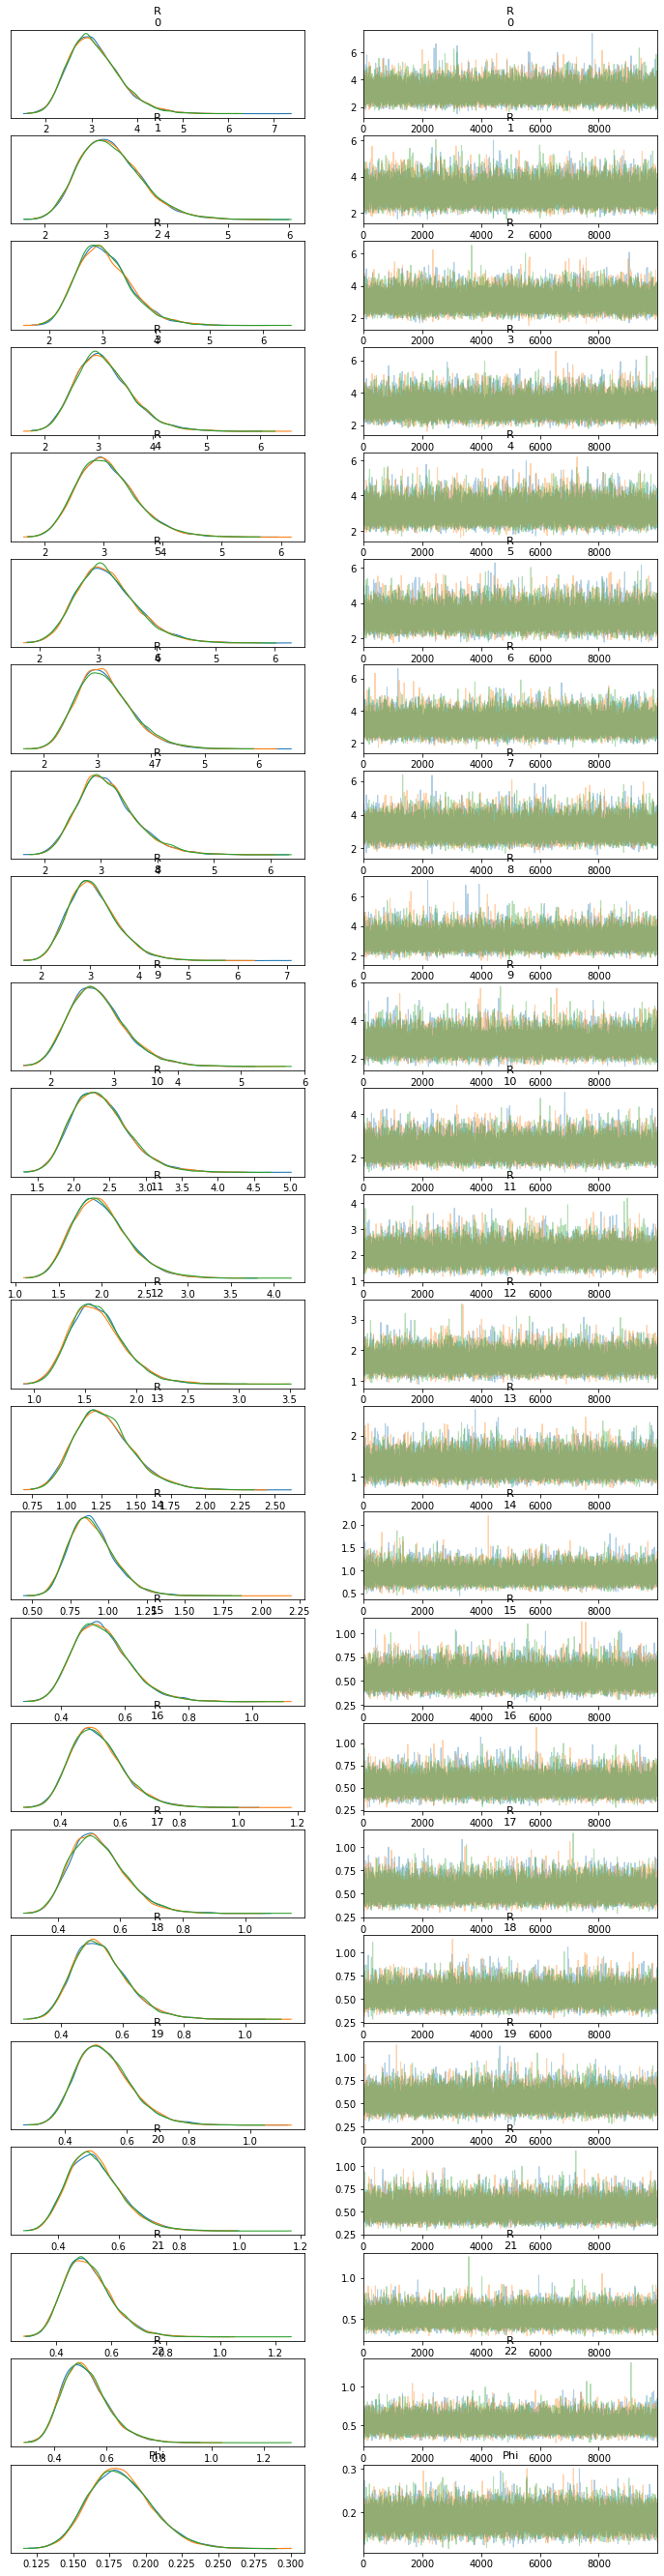

In [12]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start+1)

az.plot_trace(
    samples,
    var_names=('R', 'Phi'),
    filter_vars='like',
    compact=False)

In [13]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:-1, 5000:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))

new_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning], axis=1),
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning], 0.025, axis=1),
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning], 0.975, axis=1),
    'Central Probability': (L1+L2) * [0.95]
})

## Inference plot using class method results

In [14]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(new_intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.

